In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import make_classification
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np
import dask.dataframe as dd
import pandas as pd
# # 90% coi là "normal", 10% "abnormal" để test sau
# X = StandardScaler().fit_transform(X)
# train_X = torch.tensor(X[:1200], dtype=torch.float32)  # chỉ train bằng dữ liệu bình thường
# test_X  = torch.tensor(X, dtype=torch.float32)

df = dd.read_parquet("C:\\Users\\hoang\\Documents\\Dataset_KLTN\\scaled_output_parquet")

print(df['label'].value_counts().compute())

df = df.sample(frac=0.05, random_state=42).compute()

X_all = df[:-1].values.astype(np.float32)
# y_all = df[-1].values

# del df

# train_X, test_X = train_test_split(X_all, test_size=0.2, random_state=42)

train_X = torch.tensor(X_all, dtype=torch.float32)
X_all = torch.tensor(X_all, dtype=torch.float32)

label
2    2634124
3     486504
1    4000013
4     317183
0    1098195
Name: count, dtype: int64


In [6]:
print("CUDA available:", torch.cuda.is_available())
print("CUDA device count:", torch.cuda.device_count())
print("Current device index:", torch.cuda.current_device())
print("Current device name:", torch.cuda.get_device_name(torch.cuda.current_device()))

CUDA available: True
CUDA device count: 1
Current device index: 0
Current device name: NVIDIA GeForce GTX 1650 with Max-Q Design


In [7]:
# ================== 2. BASIC AUTOENCODER (bAE) ==================
class BasicAE(nn.Module):
    def __init__(self, in_dim=20, latent=8):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(in_dim, 12), nn.ReLU(),
            nn.Linear(12, latent)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent, 12), nn.ReLU(),
            nn.Linear(12, in_dim)
        )
    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z), z

bAE = BasicAE(in_dim=X_all.shape[1])
opt_bae = optim.Adam(bAE.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

for epoch in range(50):
    opt_bae.zero_grad()
    recon, _ = bAE(train_X)
    loss = loss_fn(recon, train_X)
    loss.backward()
    opt_bae.step()
    if (epoch+1) % 10 == 0:
        print(f"[bAE] Epoch {epoch+1}/50  Loss {loss.item():.4f}")

with torch.no_grad():
    z_normal = bAE.encoder(train_X).numpy()
    # z_all   = bAE.encoder(X_all).numpy()


[bAE] Epoch 10/50  Loss 0.9539
[bAE] Epoch 20/50  Loss 0.9404
[bAE] Epoch 30/50  Loss 0.9260
[bAE] Epoch 40/50  Loss 0.9071
[bAE] Epoch 50/50  Loss 0.8807


In [8]:
# ================== 3. ONE-CLASS SVM ==================
ocsvm = OneClassSVM(kernel="rbf", nu=0.05, gamma="scale")
y_pred = ocsvm.fit_predict(z_normal)
# y_pred = pd.Series(y_pred)
# svm_pred = ocsvm.predict(z_normal)      # 1=normal, -1=anomaly
anomaly_idx = np.where(y_pred == -1)[0]
print("Anomaly count:", len(anomaly_idx))


Anomaly count: 21382


C:\Users\hoang\AppData\Local\Temp\ipykernel_20724\3706733454.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  abIdx = df[svm_pred==-1]


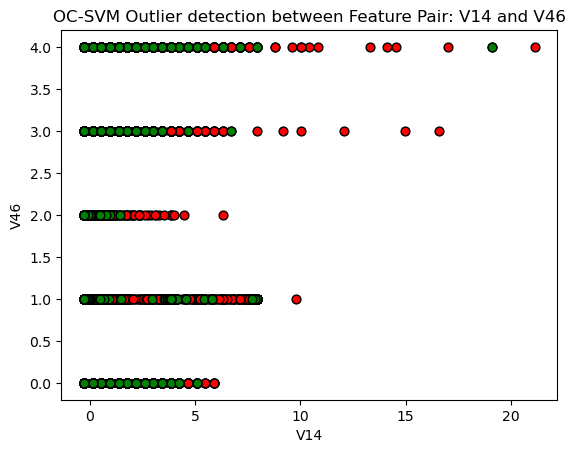

In [9]:
import matplotlib.pyplot as plt
import pandas as pd
# print(len(df.columns))
svm_pred = pd.Series(y_pred)
abIdx = df[svm_pred==-1]
# print(abIdx.iloc[:,-1])
def plot_OCSVM(i1, i2):
    plt.scatter(df.iloc[:,i1], df.iloc[:,i2],c='red',s=40, edgecolor="k")
    plt.scatter(abIdx.iloc[:,i1],abIdx.iloc[:,i2],c='green', s=40, edgecolor="k")
    plt.title("OC-SVM Outlier detection between Feature Pair: V{} and V{}".format(i1, i2))
    plt.xlabel("V{}".format(i1))
    plt.ylabel("V{}".format(i2))
#plot_OCSVM(1)  # chnage the integer value to visualize different pairs of features
plot_OCSVM(14, 46)
#plot_OCSVM(3)

In [28]:

# ================== 4. DEEP AUTOENCODER (dAE) ==================
anomaly_idx = np.array(anomaly_idx, dtype=np.int64)
abnormal_data = torch.tensor(X_all[anomaly_idx], dtype=torch.float32)

class DeepAE(nn.Module):
    def __init__(self, in_dim=20, latent=4):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(in_dim, 32), nn.ReLU(),
            nn.Linear(32, 16), nn.ReLU(),
            nn.Linear(16, latent)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent, 16), nn.ReLU(),
            nn.Linear(16, 32), nn.ReLU(),
            nn.Linear(32, in_dim)
        )
    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z), z

if len(abnormal_data) > 0:
    dAE = DeepAE(in_dim=X_all.shape[1])
    opt_dae = optim.Adam(dAE.parameters(), lr=1e-3)
    for epoch in range(30):
        opt_dae.zero_grad()
        recon, _ = dAE(abnormal_data)
        loss = loss_fn(recon, abnormal_data)
        loss.backward()
        opt_dae.step()
        if (epoch+1) % 10 == 0:
            print(f"[dAE] Epoch {epoch+1}/30  Loss {loss.item():.4f}")

    with torch.no_grad():
        latent_attack = dAE.encoder(abnormal_data)   # [N_abn, latent_dim]
        print("Deep latent vectors shape:", latent_attack.shape)
else:
    latent_attack = torch.empty(0, 4)
    print("Không có bất thường nào.")



C:\Users\hoang\AppData\Local\Temp\ipykernel_20724\2767849805.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  abnormal_data = torch.tensor(X_all[anomaly_idx], dtype=torch.float32)


[dAE] Epoch 10/30  Loss 7.3005
[dAE] Epoch 20/30  Loss 7.1478
[dAE] Epoch 30/30  Loss 6.8292
Deep latent vectors shape: torch.Size([21382, 4])
